# Homework 5

##### Data: chall.txt

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 13th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

<div class="answer-separator">
------------------------
</div>

In [38]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
import seaborn as sns
%matplotlib inline

## Question 1: We'll Always Have that Night Sampling in Monte Carlo

**Coding required**


Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of $X$:

$$h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}$$


Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:

**1.1.** Inverse Transform Sampling

**1.2.** Rejection Sampling with a uniform proposal distribution (rejection sampling in a rectangular box with uniform probability of sampling any x)


<div class="answer-separator">
------------------------
</div>

## Question 2: The Consequences of O-ring Failure can be Painful and Deadly

**Coding required**

In 1986, the space shuttle Challenger exploded during take off, killing the seven astronauts aboard. It is believed that the explosion was caused by the failure of an O-ring (a rubber ring that seals parts of the solid fuel rockets together), and that the failure was caused by the cold weather at the time of launch (31F).

In the file chall.txt, you will find temperature (in Fahrenheit) and failure data from 23 shuttle launches, where 1 stands for O-ring failure and 0 no failure. We assume that the observed temperatures are fixed and that, at temperature $t$, an O-ring fails with probability $f(\theta_{1}+\theta_{2}t)$ conditionally on $\Theta = (\theta_1, \theta_2)$.

$f(\mathbf{z})$ is defined to be the logistic function -- $f(\mathbf{ z }) = 1/(1 + \exp(\mathbf{ -z }))$ 

> **2.1.** Based on your own knowledge and experience, suggest a prior distribution for the regression parameters ($\theta_1, \theta_2$).  Make sure to explain your choice of prior. 

Our prior knowledge on this problem is quite limited, so we suggest a prior distribution that reflects this little knowledge. We do, however, pick the prior in such a way that at reasonable temperatures, the probability of a failure is small.

So, our prior is a multivariate normal with uncorrelated components.

Let's take a look at $p(a)$, the prior distribution for the intercept parameter. We take the mean of the prior distribution for $a$ to be $-1$ and its standard deviation to $2$. This means that (if the temparature coefficient is zero) that we have a mean probability of failure of slightly more than 25%. Also, we take the standard deviation to be 3 meaning that the 2 standard deviation confidence interval for the failure probabilities (again with temperature coefficient of zero) is between 0.7% and 95%.

Next, for the prior of the temperature coefficient, $p(b)$. We take it to have mean zero and standard deviation of one. This means that a two-standard deviation sample from $p(b)$ and a one degree increase in temperature can push a probability of 50% to 88%, which would mean extreme sensitivity to temperature. So this prior is definitly not too constraining.

Note that we'll center the temperature so that the above interpretation holds for the intercept parameter $a$.

Text(0.5,1,'Prior specification at mean temperature')

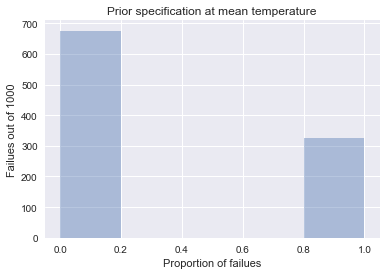

In [40]:
mu = [-1, 0]
sigma = [[2, 0], [0, 1]]

prior_samples = scipy.stats.multivariate_normal.rvs(mean=mu, cov=sigma, size=1000)
prior_means = prior_samples[:, 0] 
prior_ps = scipy.special.expit(prior_means)
prior_results = scipy.stats.bernoulli.rvs(p=prior_ps, size=prior_samples.shape[0])
sns.distplot(prior_results, kde=False, norm_hist=False)
plt.xlabel("Proportion of failues")
plt.ylabel("Failues out of 1000")
plt.title("Prior specification at mean temperature")

> **2.2.** Produce 5000-10000 samples from the posterior distribution of $\Theta $ using rejection sampling, and plot them and their marginals. (This may take a while.)

Let's read in the data:

In [41]:
chall = pd.read_csv("../data/chall.txt", header=None, names=['Temperature', 'Failure'], sep="   ")
chall['Temperature_centered'] = chall['Temperature'] - chall['Temperature'].mean()
chall.head()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,Temperature,Failure,Temperature_centered
0,66,0,-3.565217
1,70,1,0.434783
2,69,0,-0.565217
3,68,0,-1.565217
4,67,0,-2.565217


Note that in this case, we have a natural probability distribution that we can use to generate the samples for rejection samples, namely the prior distribution itself. The point is that the likelihood $p(y\vert \Theta) \leq 1$ (for a single datapoint), so the posterior $p(\Theta \vert y) \propto p(\Theta) p(y\vert \Theta) \leq p(\Theta)$. It suffices for rejection sampling that we work with the unnormalized posterior here.

In [42]:
n = chall.shape[0]
n_samples = 5000
posterior = np.empty((n_samples, 2))
n_sampled = 0
while n_sampled < n_samples:
    
    a, b = scipy.stats.multivariate_normal.rvs(mean=mu, cov=sigma)
    logits = a + chall['Temperature_centered'] * b
    p = scipy.special.expit(logits).values
    l = chall['Failure'] * p + (1-chall['Failure']) * (1-p)

    prior_l = scipy.stats.multivariate_normal.pdf([a, b], mean=mu, cov=sigma) 
    proposal_l = l.sum() * prior_l / n
    
    if np.random.uniform() <= proposal_l / prior_l:
        posterior[n_sampled, :] = [a, b]
        n_sampled += 1

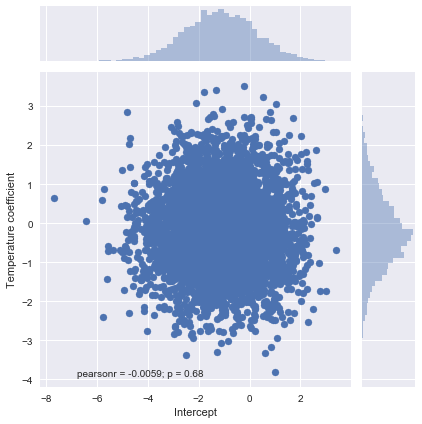

In [43]:
posterior_df = pd.DataFrame(posterior, columns=['Intercept', 'Temperature coefficient'])
sns.jointplot('Intercept', 'Temperature coefficient', data=posterior_df)

> **2.3.** Use the logit package in the `statsmodels` library to compute 68% confidence intervals on the $\theta$ parameters.  Compare those intervals with the 68% credible intervals from the posterior above. Overlay these on the above marginals plots. 

We use the formula interface to `statsmodels` to calculate the model.

In [44]:
import statsmodels.formula.api as sm
 
model = sm.logit('Failure ~ Temperature_centered', data=chall)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 6


Let's look at the summary. The coefficients seem to be similar to the ones from the Bayesian analysis.

In [45]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit              No. Iterations:     6.0000 
Dependent Variable:   Failure            Pseudo R-squared:   0.281  
Date:                 2018-10-12 22:44   AIC:                24.3152
No. Observations:     23                 BIC:                26.5862
Df Model:             1                  Log-Likelihood:     -10.158
Df Residuals:         21                 LL-Null:            -14.134
Converged:            1.0000             Scale:              1.0000 
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept            -1.1076   0.5796 -1.9108 0.0560 -2.2436  0.0285
Temperature_centered -0.2322   0.1082 -2.1450 0.0320 -0.4443 -0.0200
====================================================================

"""

In [46]:
np.sqrt(result.cov_params())

,Intercept,Temperature_centered
Intercept,0.579618,0.136308
Temperature_centered,0.136308,0.108237


Let's plot the marginals here as well:

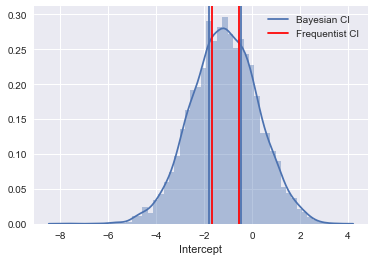

In [47]:
variable = 'Intercept'
sns.distplot(posterior_df[variable])
plt.axvline(np.percentile(posterior_df[variable], 68), label='Bayesian CI')
plt.axvline(np.percentile(posterior_df[variable], 32))
plt.axvline(result.params[variable] + np.sqrt(result.cov_params()[variable][variable]) , c='red', label='Frequentist CI')
plt.axvline(result.params[variable] - np.sqrt(result.cov_params()[variable][variable]) , c='red')

plt.legend()

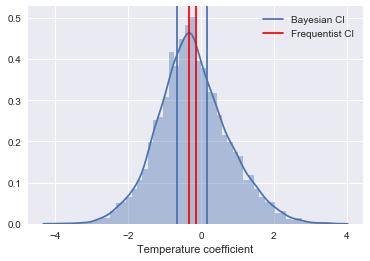

In [48]:
variable = 'Temperature coefficient'
sns.distplot(posterior_df[variable])
plt.axvline(np.percentile(posterior_df[variable], 68), label='Bayesian CI')
plt.axvline(np.percentile(posterior_df[variable], 32))
plt.axvline(result.params['Temperature_centered'] + np.sqrt(result.cov_params()['Temperature_centered']['Temperature_centered']), c='red', label='Frequentist CI')
plt.axvline(result.params['Temperature_centered'] - np.sqrt(result.cov_params()['Temperature_centered']['Temperature_centered']) , c='red')

plt.legend()

> **2.4.** Use the MLE values from `statsmodels` and the posterior mean from **2.2** at each temperature to plot the probability of failure in the frequentist and bayesian settings as a function of temperature. What do you see? 

Text(0.5,1,'Bayesian predictions are slightly regularized')

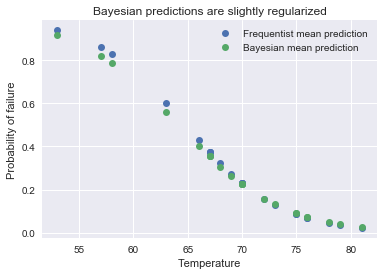

In [113]:
preds_freq = result.predict(chall['Temperature_centered'])
chall['preds_freq'] = preds_freq
chall['preds_bayes_mean'] = scipy.special.expit(posterior_df['Intercept'].mean() + posterior_df['Temperature coefficient'].mean() * chall['Temperature_centered'])

plt.plot(chall['Temperature'], chall['preds_freq'], 'o', label='Frequentist mean prediction')
plt.plot(chall['Temperature'], chall['preds_bayes_mean'], 'o', label='Bayesian mean prediction')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability of failure')
plt.title('Bayesian predictions are slightly regularized')

We see that the Bayesian predictions are slightly regularized in the sense that they predict lower probabilities of failure.

> **2.5.** Compute the mean posterior probability for an O-ring failure at $t = 31^\circ F$. To do this you must calculate the posterior at $31^\circ F$ and take the mean of the samples obtained.

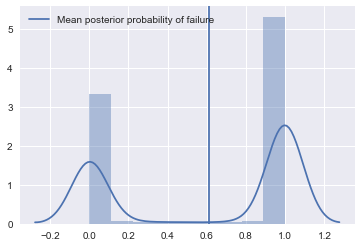

In [110]:
logits_31 = posterior_df['Intercept'] + posterior_df['Temperature coefficient'] * (31 - chall['Temperature'].mean())
p_31 = scipy.special.expit(logits_31)
sns.distplot(p_31)
plt.axvline(p_31.mean(), label='Mean posterior probability of failure')
plt.legend()

In [112]:
print("Mean posterior probability of failure at 31: {:.3f}".format(p_31.mean()))

Posterior probability of failure at 31: 0.609


This is much lower than in the frequentist setting, where it would be close to 1.

> **2.6.** You can instead obtain the probability from the posterior predictive. Use the posterior samples to obtain samples from the posterior predictive at $31^\circ F$ and calculate the fraction of failures.

In [117]:
posteror_failure_rate_31 = np.random.binomial(n=1, size=p_31.shape[0], p=p_31).mean()
print("Posterior probability of failure at 31: {:.3f}".format(p_31.mean()))

Posterior probability of failure at 31: 0.609


It's pretty much the same. This is clear by looking at the graph above, since the predictions are very localized near 0 and 1.

> **2.7.** The day before a new launch, meteorologists predict that the temperature will be $T \sim N(68, 1)$ during take-off. Estimate the probability for an O-ring failure during this take-off. (You will calculate multiple predictives at different temperatures for this purpose).

We sample as many temperatures as we have posterior samples, do predictions using our posterior and then run the probabilities through a Bernoulli. Finally, we calculate the mean failure rate. It's aroung 38%.

In [132]:
n_new = n_sampled
failures = np.empty(n_new)
T = np.random.normal(68, 1, size=n_new)
logits_68 = posterior_df['Intercept'] + posterior_df['Temperature coefficient'] * (68 - chall['Temperature'].mean())
p_68 = scipy.special.expit(logits_68)
print("Probability of failure at 68: {:.3f}".format(scipy.random.binomial(n=1, p=p_68).mean()))

Probability of failure at 68: 0.379


**Coding required**

Recall in HW 3 Question 1 we attempted to explore an edge case in using non-parametric bootstrap to construct confidence intervals.  Let's revisit the setup of that problem.
Suppose you have $\{X_1, X_2, ... X_n\}$ datapoints such that $X_i$ are independently and identically drawn from a $Unif(0, \theta)$.  Consider the extreme order statistic Y = $X_{(n)}$ = max($X_1, X_2, ... X_n$).

<div class="answer-separator">
------------------------
</div>

> **3.1.** Derive (or possibly re-write from HW3) expressions for $F_Y(y\ \vert\ n, \theta)$ the CDF of Y and $f_Y(y\ |\ n, \theta)$ the pdf of Y.

CDF
$$\begin{equation}
\begin{split}
F_Y(y\vert n,\theta) = \Pr \left(X_{(n)} \leq y \vert \theta\right) = \Pr \left(X_1, \dots, X_n \leq y \vert \theta \right) = \prod_{i = 1} ^ n \Pr\left(X_i \leq y \vert \theta \right) \\
=  \begin{cases}
 0 \text{ if } y \leq 0 \\
 \left(\frac{y}{\theta}\right) ^ n \text{ if } 0 < y \leq \theta \\
 1 \text{ if } y \geq \theta
\end{cases}
\end{split}
\end{equation}
$$

PDF

$$ f_Y(Y\vert\theta)  = \frac{d F_Y(Y\vert \theta)}{d Y} = 
\begin{cases}
0 \text{ if } Y \leq 0 \\
n Y^{n-1} / \theta ^ n \text{ if } 0 \leq Y < \theta \\
0 \text{  if } Y \geq \theta
\end{cases}$$

> **3.2.** In HW3 we had difficulty constructing confidence intervals to estimate $\theta$ with percentiles as normal so instead we introduced  pivot confidence intervals.  Let's reframe the problem so that we can use percentiles to construct our confidence intervals.  Define $Z \equiv n \cdot (\theta - Y)$ use elementary calculation to write an expression for $F_Z(z\ \vert\ n, \theta)$ the CDF of $Z$ and $f_Z(y\ |\ n, \theta)$ the pdf of Z.

$$
F_Z(z\ \vert\ n, \theta) = \Pr(Z \leq z \vert n, \theta) = \\
\Pr\left(n \left(\theta - Y\right) \leq z \vert n, \theta \right) = \\
\Pr\left(\theta - \frac{z}{n} \leq Y \vert \theta, \right) = \\
\Pr\left(Y \geq \theta - \frac{z}{n}\right) = \\
1 - \Pr\left(Y < \theta - \frac{z}{n} \right) = \\
1 - \prod_i\Pr\left(X_i < \theta - \frac{z}{n} \right) = \\
=
\begin{align}
\begin{cases}
0 & \text{if }  z \leq 0\\
1 & \text{if } z \geq n \theta \\
1 - \left( 1 - \frac{z}{\theta n}\right)^n & \text{else}  \\
\end{cases}
\end{align}
$$

The pdf is now easy to derive as well:
$$
f_Z(y\vert n, \theta)
=
\begin{align}
\begin{cases}
0 & \text{if } z \leq 0 \text{ or } z \geq n \theta \\
\left(1 - \frac{y}{\theta n}\right)^{n-1}\frac{1}{\theta} & \text{else}
\end{cases}
\end{align} \\
$$

> **3.3.** What is the limiting distribution of Z (as $n \rightarrow \infty$)?  Plot that limiting distribution.

From the expression above, it's clear that this distribuion converges to an **exponential distribution with mean $\theta$** in the limit $n\rightarrow \infty$.

Text(0.5,1,'Limiting distribution is exponential with mean $\\theta=10$')

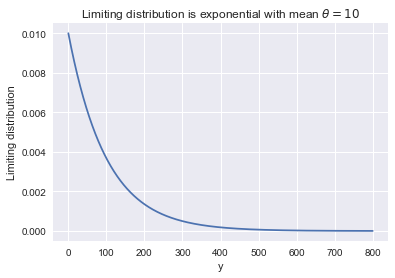

In [2]:
x = np.arange(0, 800, 0.01)
theta = 100
plt.plot(x, scipy.stats.expon.pdf(x, scale=theta))
plt.xlabel("y")
plt.ylabel("Limiting distribution")
plt.title(r"Limiting distribution is exponential with mean $\theta=10$")

> **3.4. Use scipy/numpy to generate 100000 samples {$X_i$} from Unif(0,100) (i.e. let $\theta$ = 100).  Store them in Based on your data sample, what's $\hat{\theta}$ the empirical estimate for $\theta$.**

In [3]:
np.random.seed(0)
theta = 100
n_samples = 100000
uniform_samples = np.random.uniform(high=theta, size=n_samples)
theta_hat = np.max(uniform_samples)
print(r"Empirical estimate for theta is {:.3f}".format(theta_hat))

Empirical estimate for theta is 99.998


> **3.5.** Use non-parametric bootstrap to generate a sampling distribution of 10000 estimates for $Z$ by substituting $\hat{\theta}$ for $\theta$.  Plot a histogram of your sampling distribution.  Make sure to title and label the plot.  Use percentiles to construct the 10% and 68% bootstrap confidence intervals.  Plot them in your graph. **Hint:  Should the confidence intervals be symmetric around the estimate $\hat{\theta}$**?


In [4]:
n_bootstraps = 1000
Z_bootstrapped = np.empty(n_bootstraps)
for i in range(n_bootstraps):
    resampled = np.random.choice(uniform_samples, replace=True, size=n_samples)
    theta_hat_resampled = np.max(resampled)
    Z_bootstrapped[i] = n_samples * (theta_hat - theta_hat_resampled)

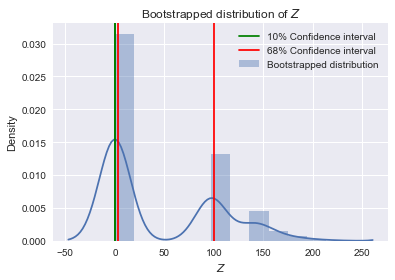

In [5]:
sns.distplot(Z_bootstrapped, label='Bootstrapped distribution')
plt.axvline(np.percentile(Z_bootstrapped, q=45), c='green', label='10% Confidence interval')
plt.axvline(np.percentile(Z_bootstrapped, q=55), c='green')
plt.axvline(np.percentile(Z_bootstrapped, q=16) + 3, c='red', label='68% Confidence interval')
plt.axvline(np.percentile(Z_bootstrapped, q=84) + 3, c='red')
plt.title(r"Bootstrapped distribution of $Z$")
plt.xlabel(r"$Z$")
plt.ylabel("Density")
plt.legend()

We see that the bootstrap 10% confidence interval is localized at zero. The 68% confidence interval, on the other hand, stretches between 0 and the next biggest number (roughly 100).

Actually, the bootstrapped distribution is quite interesting to look at. We see that the distribution is discrete. Thinking about the bootstrap for a moment actually reveals why: what's the probability that a sampled point $x$ is not in the resampled set (in the limit of $n \rightarrow \infty$, where $n$ is the sample size)? It's the probability that $x$ is not taken in any of the $n$ choices, i.e. $(1 - \frac{1}{n})^n \approx e^{-1}$. Thus, in most cases the bootstrapped estaimate of $Z$ is 0. 

For the next bump in the graph, we need the largest and second largest element not be included in the bootstrapped dataset. 

> **3.6.** Make an argument that we can construct a bootstrap confidence interval that always mismatches the limiting distribution.

The argument above actually suffices: once we draw enough random samples, we can be sure that in $1 - e^{-1} \approx 63$% percent of cases, the largest element is included. Thus, we expect, that confidence intervals up to roughly 46% are localized at a point and thus can't correspond to the corresponding intervals of the limiting distribution. This is because the limiting distribution is continuous and nonzero on $\mathbb R_+$. Thus, the $\alpha$ confidence interval is always bigger than the $\beta$ confidence interval if $\alpha > \beta$.

In [6]:
1 - np.exp(-1)

0.6321205588285577

> **1.8.** Let's switch to being Bayesian.  In 1.1 we came up with an expression for the likelihood $f_Y(y\ |\ n, \theta)$.  Use the [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution) to construct a prior for $\theta$.  What are some reasonable values to use for the scale and shape?

From the linked Wikipedia article above, the CDF of the Pareto distribution is

$$
F_X(x\vert \alpha, x_m) =
\begin{align}
\begin{cases}
1 - \left(\frac{x_m}{x}\right)^\alpha & x \geq x_m\\
0 & x < x_m
\end{cases}
\end{align}
$$

Correspondingly, the likelihood is

$$
f_X(x\vert \alpha, x_m) =
\begin{align}
\begin{cases}
\frac{\alpha x_m^{\alpha}}{x^{\alpha + 1}} & x \geq x_m\\
0 & x < x_m
\end{cases}
\end{align}
$$

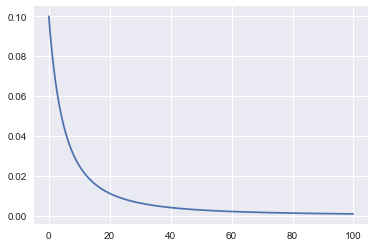

In [7]:
x = np.arange(0, 100, 0.1)
plt.plot(x, scipy.stats.pareto.pdf(x, loc=-10, b=1, scale=10))


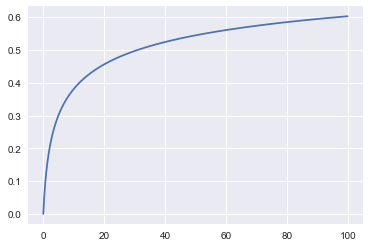

In [8]:
plt.plot(x, scipy.stats.pareto.cdf(x, loc=-1, b=.2))

> **1.9.** Write down an expression for the posterior distribution $f_Y(\theta\ |\ n, y)$ 

> **1.10.** Draw 10000 posterior samples and plot a histogram of the posterior distribution.  Use percentiles to construct the 68% HPD.  Plot the posterior distribution and mark the HPD on your plot.

Text(0.5,1,'Posterior density of $\\theta$')

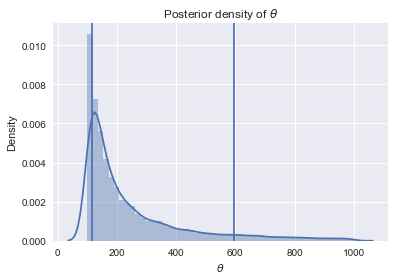

In [9]:
posterior = scipy.stats.pareto.rvs(b=1, loc=10, scale=(theta_hat-10), size=10000)
sns.distplot(posterior[posterior < 1000], hist=True)
x = np.arange(0, 600, 1)
y = scipy.stats.expon.pdf(x, scale=theta)
plt.axvline(np.percentile(posterior, 16))
plt.axvline(np.percentile(posterior, 84))
plt.xlabel(r"$\theta$")
plt.ylabel("Density")
plt.title(r"Posterior density of $\theta$")

Let's also construct the posterior density of $Z = n(\theta - Y)$.

In [30]:
n_Zs = 1000
n = 100000
Z_bayes = np.empty(n_Zs)
for i in range(n_Zs):
    uniforms = np.random.uniform(high=posterior[i], size=n)
    Z = n * (posterior[i] - uniforms.max())
    Z_bayes[i] = Z

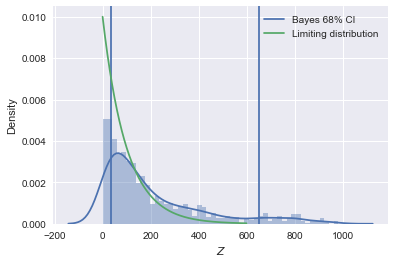

In [36]:
sns.distplot(Z_bayes[Z_bayes < 1000], bins=50)
plt.axvline(np.percentile(Z_bayes, 16), label="Bayes 68% CI")
plt.axvline(np.percentile(Z_bayes, 84))
x = np.arange(0, 600, 1)
y = scipy.stats.expon.pdf(x, scale=theta)
plt.plot(x, y, label='Limiting distribution')
plt.xlabel(r"$Z$")
plt.ylabel("Density")
plt.legend()

> **1.11.** How does th 68% HPD compare with the confidence interval generated from bootstrapping?  Why doesn't the bayesian interval construction suffer the same concerns you noted in 1.6

Let's compare the Bayesian confidence interval to the bootstrapped one. The first thing to note is that it is continuous. This is certainly a desirable feature. That this happens is pretty clear: we get different samples for each draw (`i` in the code chunk above), so the danger that the very same points are used to estimate $Z$ is not given.

Also note that the distribution of $Z$ does not follow the limiting distribution. This is because the posterior predictive samples are drawn from a (continuous) mixture of the limiting distribution. If we kept one parameter $\theta$ fixed and sampled from $\text{Unif}(0, \theta)$ and then calculate $Z$, we would get the limiting distribution.